In [148]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, Lasso
import seaborn as sns
import numpy as np
import utils
from Model import Model
import matplotlib.pyplot as plt
from tqdm import tqdm
from PrecisionMatrixBuilder import PrecisionMatrixBuilder
from Forecaster import Forecaster
from MyDataLoader import MyDataLoader
from PortfolioConstructor import PortfolioConstructor
from BackTester import BackTester
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, GroupNormalizer, Baseline
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch
import pytorch_lightning as pl

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

Stellantis and WLN have a lot of missing prices compared to the other stocks in the CAC40: we exclude them from this analysis.

In [149]:
dataloader = MyDataLoader()
full_dataset, stock_names, time_index = dataloader.load_full_dataset_array()

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [150]:
column_names = dataloader.load_feature_names()

In [151]:
tscv = list(utils.time_series_cross_validation(full_dataset, time_index, n_splits=10, valid_size=66, test_size=66))

In [153]:
config = utils.load_config()
alphas = config["alphas"]
thetas = config["thetas"]
lambdas = config["lambdas"]
capital = config["capital"]

In [154]:
returns = dataloader.load_returns()

In [155]:
# precision_matrix_builder = PrecisionMatrixBuilder(returns = returns, window = 512, alphas = alphas, thetas = thetas)
# prec_mat = precision_matrix_builder.get_precision_matrix()

In [156]:
import pickle
with open("precision_mat.pkl", "rb") as f:
    prec_mat = pickle.load(f)

In [157]:
benchmark_returns = dataloader.load_benchmark(date_index=time_index)
risk_free = dataloader.load_risk_free_rate(time_index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [187]:
class LinearRegression(torch.nn.Module):

    def __init__(self, input_dim, lr = 1e-3):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1, dtype = torch.float64)
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)

    def forward(self, x):
        return self.linear(x)
    
    def fit(self, train_dataloader, validation_dataloader, epochs = 10, max_patience = 3, min_delta = 0.001):
        self.train()
        prev_val_loss = np.inf
        patience = 0
        for epoch in range(epochs):
            curr_val_loss = 0
            for batch in train_dataloader:
                x, y = batch
                y_hat = self(x)
                loss = self.loss(y_hat, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            for batch in validation_dataloader:
                x, y = batch
                y_hat = self(x)
                val_loss = self.loss(y_hat, y)
                curr_val_loss+=val_loss
            if abs(curr_val_loss - prev_val_loss) < min_delta:
                patience+=1
            else:
                patience = 0
            if patience >= max_patience:
                break
        return self
    
    def predict(self, dataloader):
        with torch.no_grad():
            predictions = []
            for batch in dataloader:
                x, _ = batch
                y_hat = self(x)
                predictions.append(y_hat)
            return torch.cat(predictions).numpy().flatten() # (n,) np.array

In [195]:
from Forecaster import Forecaster
forecaster = Forecaster(full_dataset, stock_names, time_index, valid_size=66, test_size=66, n_splits=10)

In [204]:
model_1 = Model("Lasso", "regression", Lasso(0.05))
model_2 = Model("LogisticRegression", "classification", LogisticRegression(C = 0.2, penalty="l1", solver="saga"))
model_3 = Model("LinearRegression", "regression", LinearRegression(14))

models = [model_1, model_2, model_3]

In [207]:
forecasts_val, forecasts_test, weights_valid, weights_test, opt_param_dict, valid_index_full, test_index_full = forecaster.evaluate_test_models(models = models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

10it [05:58, 35.83s/it]


In [213]:
weights_test_full_lasso = weights_test["Lasso"]
weights_test_full_logistic = weights_test["LogisticRegression"]
weights_test_full_linear = weights_test["LinearRegression"]

Text(0, 0.5, 'MSE')

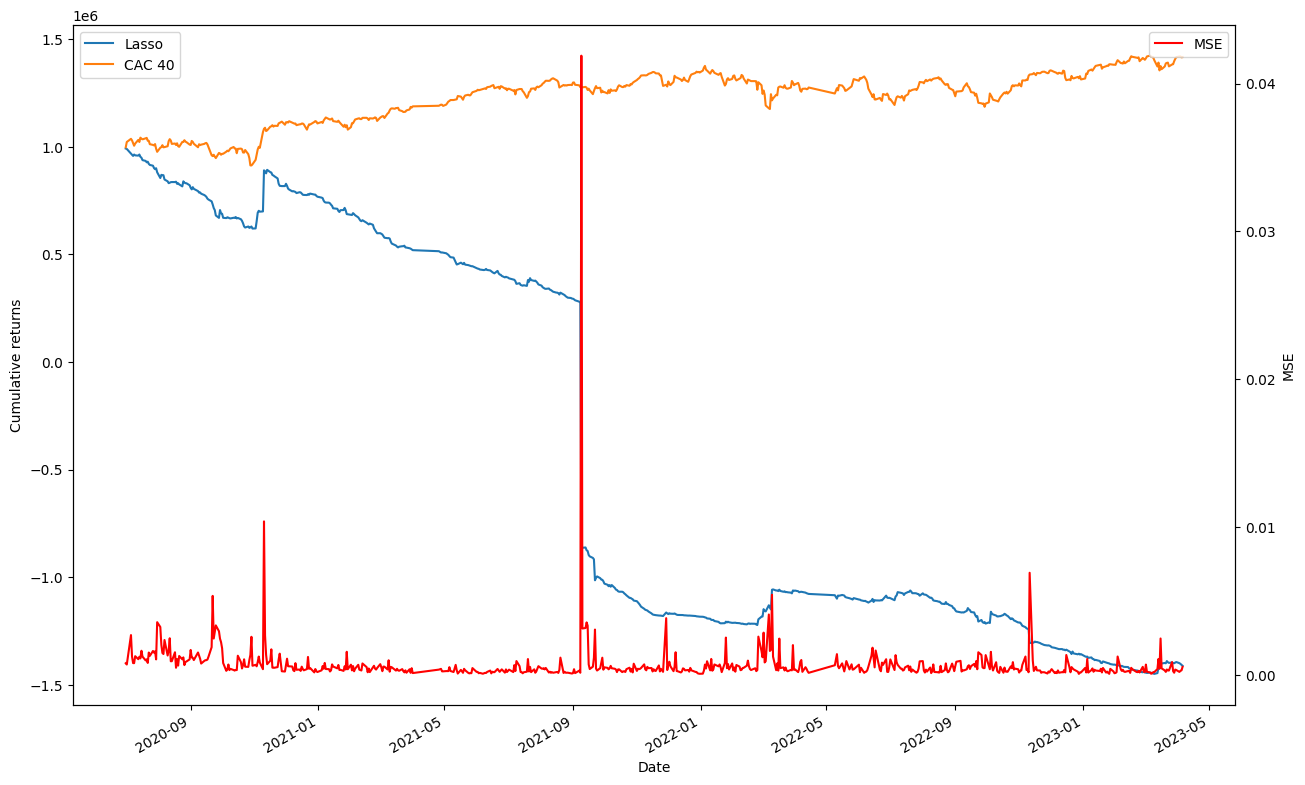

In [209]:
backtest = BackTester(weights_test_full_lasso, returns, capital, risk_free, benchmark=benchmark_returns, name = "Lasso")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["MSE"] = (forecasts_test["Lasso"] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Lasso", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "MSE", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("MSE")

In [210]:
cum_returns["MSE"].sum()

0.46259962194397763

In [211]:
backtest_statistics

Yearly excess returns         -0.922446
Yearly standard deviation      0.726578
Max DD                       320.296525
Yearly Sharpe                 -1.269575
Yearly Calmar                 -0.002880
Yearly Sortino                -1.133783
Daily Turnover                 0.568273
dtype: float64

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

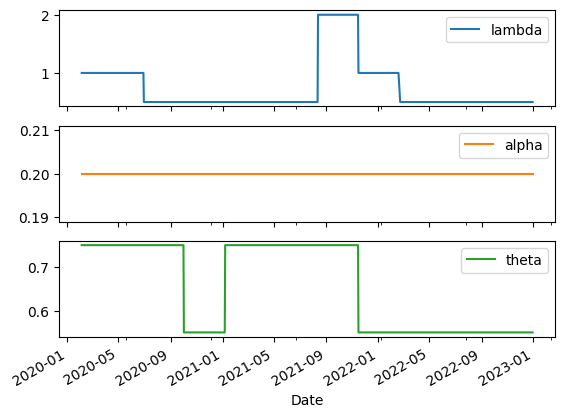

In [212]:
opt_param_dict["Lasso"].plot(subplots = True)

Text(0, 0.5, 'MSE')

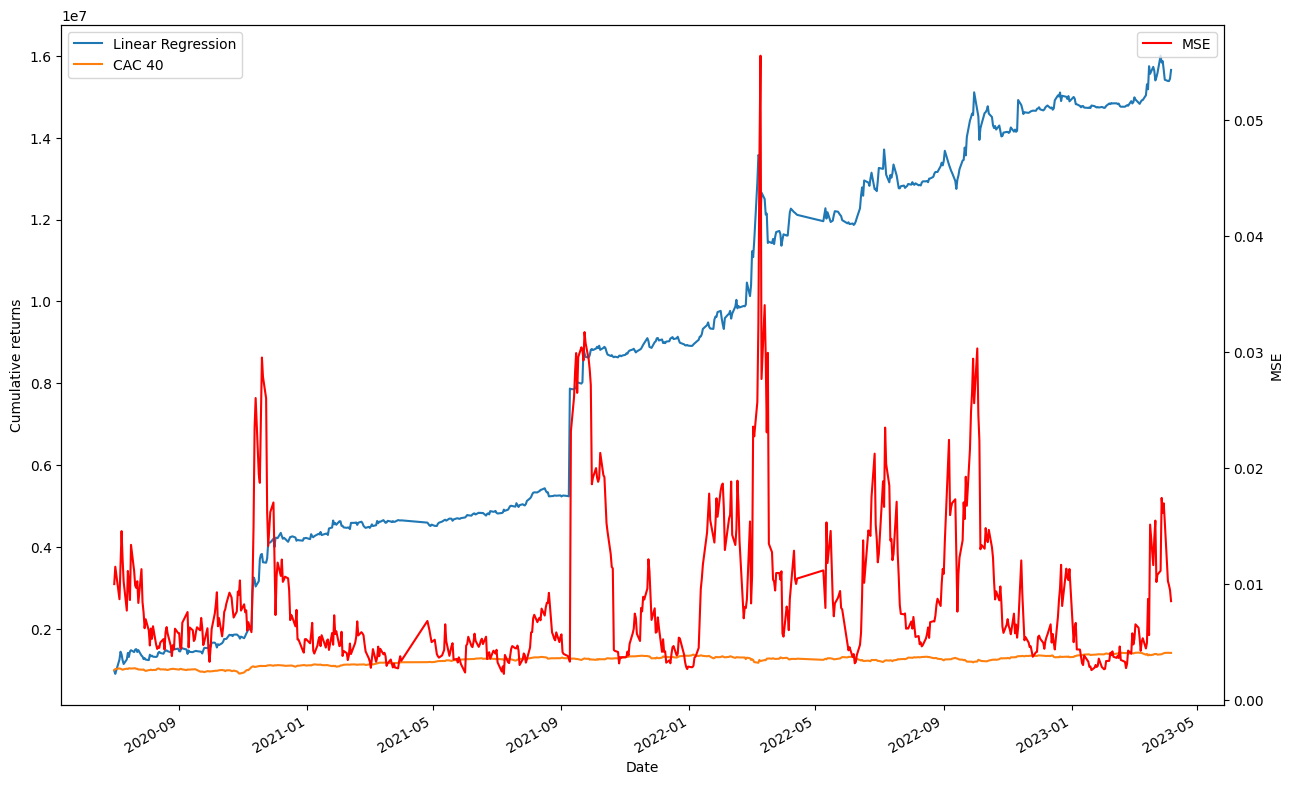

In [216]:
backtest = BackTester(weights_test_full_linear, returns, capital, risk_free, benchmark=benchmark_returns, name = "Linear Regression")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["MSE"] = (forecasts_test["LinearRegression"] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Linear Regression", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "MSE", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("MSE")

In [217]:
backtest_statistics

Yearly excess returns        5.603746
Yearly standard deviation    3.038003
Max DD                       4.629712
Yearly Sharpe                1.844550
Yearly Calmar                1.210388
Yearly Sortino               2.794014
Daily Turnover               1.839745
dtype: float64

Text(0, 0.5, 'Misclassification rate')

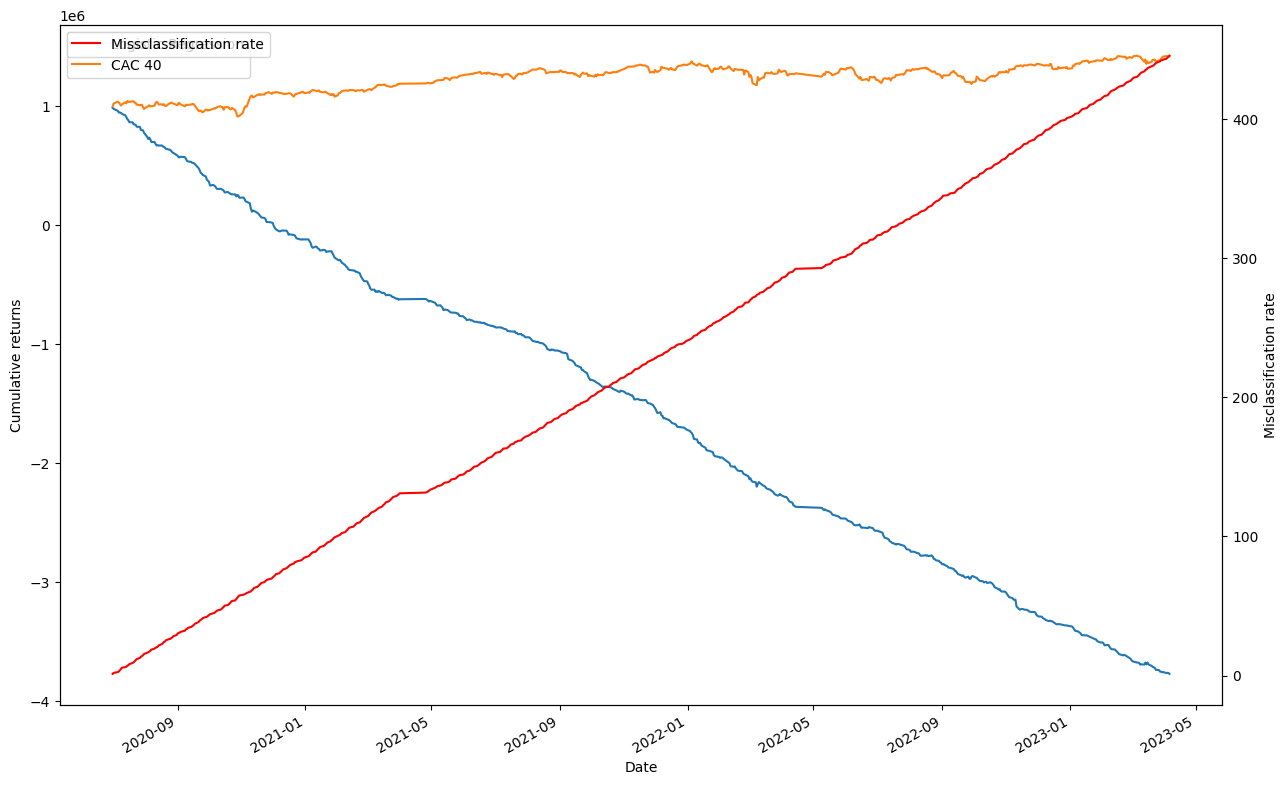

In [218]:
backtest = BackTester(weights_test_full_logistic, returns, capital, risk_free, benchmark = benchmark_returns, name = "Logistic Regression")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["Missclassification rate"] = (forecasts_test["LogisticRegression"] != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Logistic Regression", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("Misclassification rate")

In [219]:
(forecasts_test["LogisticRegression"] != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).mean()

0.6746012759170656

In [220]:
backtest_statistics

Yearly excess returns         -1.823427
Yearly standard deviation      0.133675
Max DD                       345.747608
Yearly Sharpe                -13.640795
Yearly Calmar                 -0.005274
Yearly Sortino               -15.904763
Daily Turnover                 0.757855
dtype: float64